# Task 3: Statistical Hypothesis Testing

## Overview
This notebook performs comprehensive statistical hypothesis testing to validate findings from the EDA and provide statistical evidence for business decisions.

### Key Hypotheses to Test
1. **Risk differences across provinces**
2. **Risk differences between zip codes**
3. **Risk differences between genders**
4. **Risk differences between automobile makes**

---

## 1. Setup and Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, kruskal
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
import os
import logging
from pathlib import Path

# Create necessary directories
log_dir = Path('../logs')
results_dir = Path('../results/statistical_testing')
log_dir.mkdir(exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Configure logging with UTF-8 encoding to handle special characters
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_dir / 'statistical_testing.log', encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Configuration
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set significance level
ALPHA = 0.05

logger.info('Statistical Testing Environment Setup Complete')
logger.info(f'Significance Level (alpha): {ALPHA}')  # Use 'alpha' instead of α symbol
print('Statistical Testing Environment Setup Complete')
print(f'Significance Level (alpha): {ALPHA}')  # Use 'alpha' instead of α symbol

2025-06-18 00:22:50,995 - INFO - Statistical Testing Environment Setup Complete
2025-06-18 00:22:50,996 - INFO - Significance Level (alpha): 0.05


Statistical Testing Environment Setup Complete
Significance Level (alpha): 0.05


In [3]:
# Load processed data from EDA
data_path = '../data/processed/insurance_data_processed.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    logger.info(f'Data loaded successfully: {df.shape[0]:,} records')
    print(f'Data loaded successfully: {df.shape[0]:,} records')
else:
    # Generate synthetic data if processed data not available
    logger.warning('Processed data not found. Generating synthetic data...')
    print('WARNING: Processed data not found. Generating synthetic data...')
    
    np.random.seed(42)
    n_samples = 10000
    
    df = pd.DataFrame({
        'PolicyID': range(1, n_samples + 1),
        'Province': np.random.choice(['Western Cape', 'Gauteng', 'KwaZulu-Natal', 'Eastern Cape', 'Free State'], n_samples),
        'PostalCode': np.random.randint(1000, 9999, n_samples),
        'Gender': np.random.choice(['Male', 'Female'], n_samples),
        'VehicleType': np.random.choice(['Sedan', 'SUV', 'Hatchback', 'Truck', 'Sports'], n_samples),
        'VehicleMake': np.random.choice(['Toyota', 'Volkswagen', 'Ford', 'BMW', 'Mercedes'], n_samples),
        'TotalPremium': np.random.lognormal(8.5, 0.3, n_samples),
        'TotalClaims': np.random.exponential(3000, n_samples) * np.random.binomial(1, 0.15, n_samples),
    })
    
    # Calculate derived metrics
    df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']
    df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
    
    logger.info(f'Synthetic data generated: {df.shape[0]:,} records')
    print(f'Synthetic data generated: {df.shape[0]:,} records')

# Display basic statistics
print('\nDataset Overview:')
print(f'Total Policies: {len(df):,}')
print(f'Claim Rate: {df["HasClaim"].mean():.3f}')
print(f'Average Loss Ratio: {df["LossRatio"].mean():.3f}')

logger.info(f'Dataset loaded with {len(df):,} policies, claim rate: {df["HasClaim"].mean():.3f}')

2025-06-18 00:23:00,278 - INFO - Data loaded successfully: 10,000 records
2025-06-18 00:23:00,339 - INFO - Dataset loaded with 10,000 policies, claim rate: 0.145


Data loaded successfully: 10,000 records

Dataset Overview:
Total Policies: 10,000
Claim Rate: 0.145
Average Loss Ratio: 0.092


## 2. Statistical Testing Framework

In [4]:
# Define helper functions for statistical testing

def interpret_p_value(p_value, alpha=ALPHA):
    """Interpret p-value and return conclusion"""
    if p_value < alpha:
        return f"REJECT H0 (p={p_value:.4f} < α={alpha}): Statistically significant difference"
    else:
        return f"FAIL TO REJECT H0 (p={p_value:.4f} ≥ α={alpha}): No statistically significant difference"

def effect_size_cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1-1)*group1.var() + (n2-1)*group2.var()) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

def cramers_v(chi2, n, r, k):
    """Calculate Cramer's V effect size for chi-square test"""
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def display_test_results(test_name, statistic, p_value, effect_size=None, interpretation=None):
    """Display formatted test results"""
    print(f"\n{'='*60}")
    print(f"TEST: {test_name}")
    print(f"{'='*60}")
    print(f"Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    if effect_size is not None:
        print(f"Effect Size: {effect_size:.4f}")
    print(f"\n{interpret_p_value(p_value)}")
    if interpretation:
        print(f"\nInterpretation: {interpretation}")
    print(f"{'='*60}")
    
    # Log results
    logger.info(f"{test_name} - Statistic: {statistic:.4f}, P-value: {p_value:.4f}")

def interpret_effect_size(effect_size, test_type):
    """Interpret effect size based on test type"""
    if test_type == 'eta_squared':
        if effect_size < 0.01:
            return "Small effect"
        elif effect_size < 0.06:
            return "Medium effect"
        else:
            return "Large effect"
    elif test_type == 'cramers_v':
        if effect_size < 0.1:
            return "Small association"
        elif effect_size < 0.3:
            return "Medium association"
        else:
            return "Strong association"
    elif test_type == 'cohens_d':
        if abs(effect_size) < 0.2:
            return "Small effect"
        elif abs(effect_size) < 0.8:
            return "Medium effect"
        else:
            return "Large effect"
    return "Unknown"

logger.info('Helper functions defined successfully')
print('Helper functions defined successfully')

2025-06-18 00:23:05,607 - INFO - Helper functions defined successfully


Helper functions defined successfully


## 3. Hypothesis Test 1: Risk Differences Across Provinces

### H0: There are no significant differences in risk (loss ratio) across provinces
### H1: There are significant differences in risk across provinces

In [5]:
# Test 1A: ANOVA for Loss Ratio across Provinces
print('TESTING: Risk Differences Across Provinces')
print('\n1A. ANOVA Test for Loss Ratio by Province')

# Prepare data
province_groups = [group['LossRatio'].dropna() for name, group in df.groupby('Province')]
province_names = df['Province'].unique()

# Perform ANOVA
f_stat, p_value_anova = f_oneway(*province_groups)

# Calculate effect size (eta-squared)
ss_between = sum(len(group) * (group.mean() - df['LossRatio'].mean())**2 for group in province_groups)
ss_total = ((df['LossRatio'] - df['LossRatio'].mean())**2).sum()
eta_squared = ss_between / ss_total

display_test_results(
    "ANOVA: Loss Ratio by Province",
    f_stat, p_value_anova, eta_squared,
    "Measures if provinces have significantly different average loss ratios"
)

print(f"Effect Size Interpretation: {interpret_effect_size(eta_squared, 'eta_squared')}")

# Post-hoc analysis if significant
if p_value_anova < ALPHA:
    print("\nPost-hoc Analysis: Tukey HSD Test")
    tukey_results = pairwise_tukeyhsd(df['LossRatio'], df['Province'], alpha=ALPHA)
    print(tukey_results)
    logger.info('Tukey HSD test performed for province differences')

2025-06-18 00:23:14,203 - INFO - ANOVA: Loss Ratio by Province - Statistic: 1.1157, P-value: 0.3470


TESTING: Risk Differences Across Provinces

1A. ANOVA Test for Loss Ratio by Province

TEST: ANOVA: Loss Ratio by Province
Test Statistic: 1.1157
P-value: 0.3470
Effect Size: 0.0004

FAIL TO REJECT H0 (p=0.3470 ≥ α=0.05): No statistically significant difference

Interpretation: Measures if provinces have significantly different average loss ratios
Effect Size Interpretation: Small effect


2025-06-18 00:23:21,622 - INFO - Chi-square: Claim Frequency by Province - Statistic: 1.5760, P-value: 0.8131



1B. Chi-square Test for Claim Frequency by Province

Contingency Table:
HasClaim          0    1
Province                
Eastern Cape   1239  213
Free State      830  131
Gauteng        2191  362
KwaZulu-Natal  1697  284
Western Cape   2594  459

TEST: Chi-square: Claim Frequency by Province
Test Statistic: 1.5760
P-value: 0.8131
Effect Size: 0.0126

FAIL TO REJECT H0 (p=0.8131 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if claim frequency varies significantly across provinces
Effect Size Interpretation: Small association


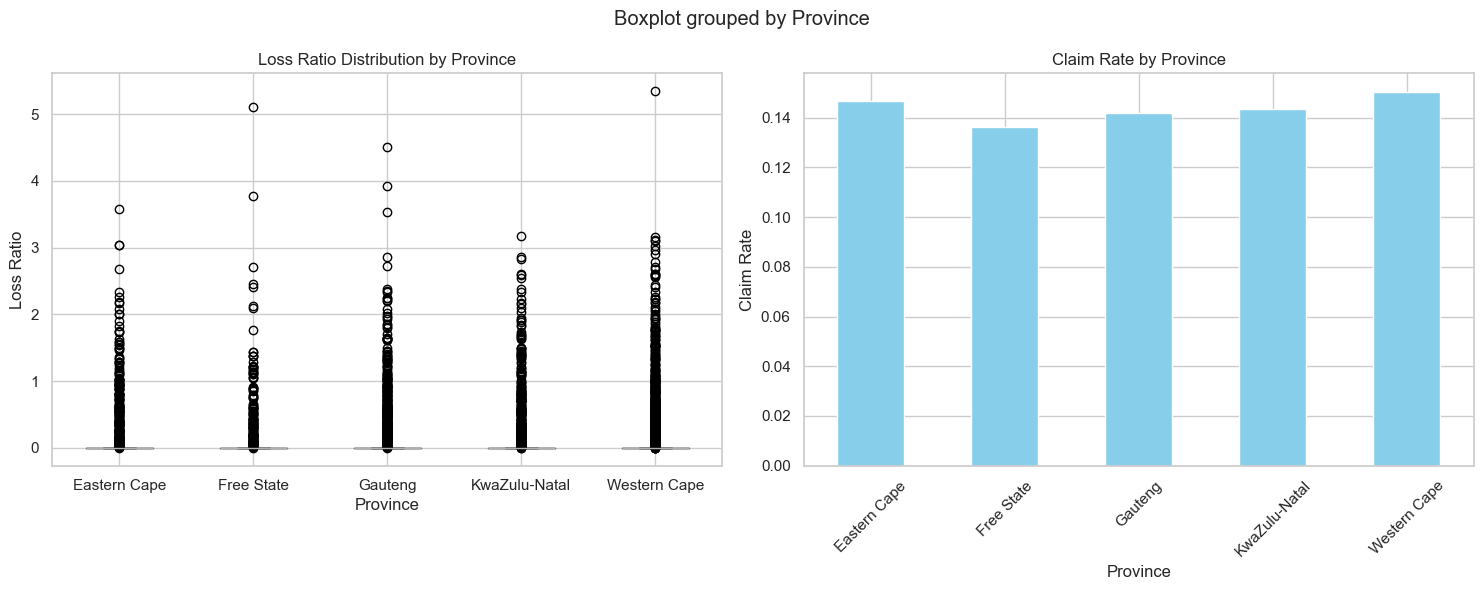

In [6]:
# Test 1B: Chi-square test for claim frequency by province
print('\n1B. Chi-square Test for Claim Frequency by Province')

# Create contingency table
contingency_table = pd.crosstab(df['Province'], df['HasClaim'])
print('\nContingency Table:')
print(contingency_table)

# Perform chi-square test
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

# Calculate Cramer's V
n = contingency_table.sum().sum()
r, k = contingency_table.shape
cramers_v_value = cramers_v(chi2_stat, n, r, k)

display_test_results(
    "Chi-square: Claim Frequency by Province",
    chi2_stat, p_value_chi2, cramers_v_value,
    "Tests if claim frequency varies significantly across provinces"
)

print(f"Effect Size Interpretation: {interpret_effect_size(cramers_v_value, 'cramers_v')}")

# Visualize province differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss ratio by province
df.boxplot(column='LossRatio', by='Province', ax=ax1)
ax1.set_title('Loss Ratio Distribution by Province')
ax1.set_xlabel('Province')
ax1.set_ylabel('Loss Ratio')

# Claim rate by province
claim_rates = df.groupby('Province')['HasClaim'].mean()
claim_rates.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Claim Rate by Province')
ax2.set_xlabel('Province')
ax2.set_ylabel('Claim Rate')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Hypothesis Test 2: Risk Differences Between Zip Codes

### H0: There are no significant differences in risk between zip codes
### H1: There are significant differences in risk between zip codes

In [7]:
# Test 2: Risk differences by postal code (grouped)
print('TESTING: Risk Differences Between Zip Codes')

# Group postal codes into regions for analysis
df['PostalRegion'] = pd.cut(df['PostalCode'], bins=5, labels=['Region1', 'Region2', 'Region3', 'Region4', 'Region5'])

# Test 2A: ANOVA for Loss Ratio across postal regions
print('\n2A. ANOVA Test for Loss Ratio by Postal Region')

region_groups = [group['LossRatio'].dropna() for name, group in df.groupby('PostalRegion')]
f_stat_region, p_value_region = f_oneway(*region_groups)

# Calculate effect size
ss_between_region = sum(len(group) * (group.mean() - df['LossRatio'].mean())**2 for group in region_groups)
eta_squared_region = ss_between_region / ss_total

display_test_results(
    "ANOVA: Loss Ratio by Postal Region",
    f_stat_region, p_value_region, eta_squared_region,
    "Tests if different postal regions have significantly different risk levels"
)

print(f"Effect Size Interpretation: {interpret_effect_size(eta_squared_region, 'eta_squared')}")

# Test 2B: Chi-square for claim frequency by postal region
print('\n2B. Chi-square Test for Claim Frequency by Postal Region')

contingency_region = pd.crosstab(df['PostalRegion'], df['HasClaim'])
chi2_region, p_value_chi2_region, dof_region, expected_region = chi2_contingency(contingency_region)

n_region = contingency_region.sum().sum()
r_region, k_region = contingency_region.shape
cramers_v_region = cramers_v(chi2_region, n_region, r_region, k_region)

display_test_results(
    "Chi-square: Claim Frequency by Postal Region",
    chi2_region, p_value_chi2_region, cramers_v_region,
    "Tests if claim frequency varies significantly across postal regions"
)

print(f"Effect Size Interpretation: {interpret_effect_size(cramers_v_region, 'cramers_v')}")

2025-06-18 00:23:28,934 - INFO - ANOVA: Loss Ratio by Postal Region - Statistic: 1.2619, P-value: 0.2825
2025-06-18 00:23:28,974 - INFO - Chi-square: Claim Frequency by Postal Region - Statistic: 3.7788, P-value: 0.4368


TESTING: Risk Differences Between Zip Codes

2A. ANOVA Test for Loss Ratio by Postal Region

TEST: ANOVA: Loss Ratio by Postal Region
Test Statistic: 1.2619
P-value: 0.2825
Effect Size: 0.0005

FAIL TO REJECT H0 (p=0.2825 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if different postal regions have significantly different risk levels
Effect Size Interpretation: Small effect

2B. Chi-square Test for Claim Frequency by Postal Region

TEST: Chi-square: Claim Frequency by Postal Region
Test Statistic: 3.7788
P-value: 0.4368
Effect Size: 0.0194

FAIL TO REJECT H0 (p=0.4368 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if claim frequency varies significantly across postal regions
Effect Size Interpretation: Small association


## 5. Hypothesis Test 3: Risk Differences Between Genders

### H0: There are no significant differences in risk between genders
### H1: There are significant differences in risk between genders

2025-06-18 00:23:36,958 - INFO - T-test: Loss Ratio by Gender - Statistic: 0.5247, P-value: 0.5998
2025-06-18 00:23:36,973 - INFO - Chi-square: Claim Frequency by Gender - Statistic: 0.6230, P-value: 0.4299


TESTING: Risk Differences Between Genders

3A. Independent T-test for Loss Ratio by Gender

TEST: T-test: Loss Ratio by Gender
Test Statistic: 0.5247
P-value: 0.5998
Effect Size: 0.0105

FAIL TO REJECT H0 (p=0.5998 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if males and females have significantly different average loss ratios
Effect Size Interpretation: Small effect

3B. Chi-square Test for Claim Frequency by Gender

TEST: Chi-square: Claim Frequency by Gender
Test Statistic: 0.6230
P-value: 0.4299
Effect Size: 0.0079

FAIL TO REJECT H0 (p=0.4299 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if claim frequency varies significantly between genders
Effect Size Interpretation: Small association


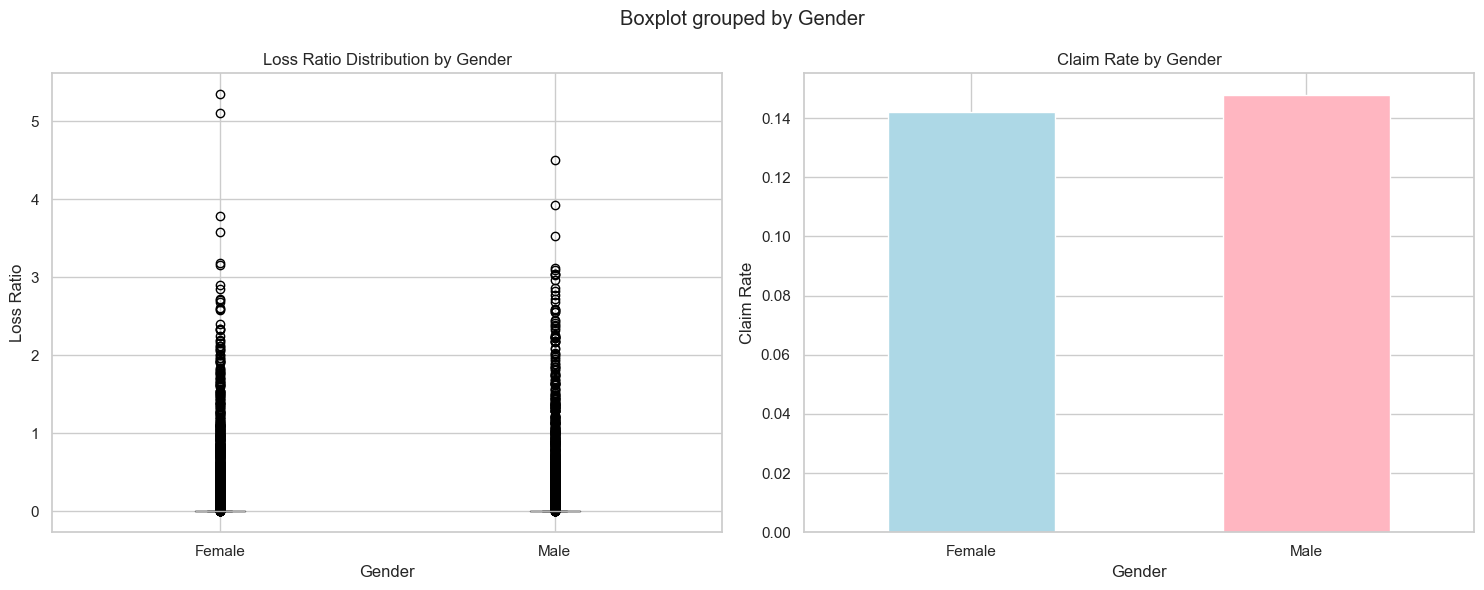


Summary Statistics by Gender:
       LossRatio         HasClaim TotalPremium TotalClaims
            mean     std     mean         mean        mean
Gender                                                    
Female    0.0904  0.3322   0.1419    5163.7169    428.7544
Male      0.0939  0.3396   0.1477    5159.9215    446.7831


In [8]:
# Test 3: Gender-based risk analysis
print('TESTING: Risk Differences Between Genders')

# Test 3A: T-test for Loss Ratio between genders
print('\n3A. Independent T-test for Loss Ratio by Gender')

male_loss_ratio = df[df['Gender'] == 'Male']['LossRatio'].dropna()
female_loss_ratio = df[df['Gender'] == 'Female']['LossRatio'].dropna()

# Perform t-test
t_stat, p_value_ttest = ttest_ind(male_loss_ratio, female_loss_ratio)

# Calculate Cohen's d effect size
cohens_d = effect_size_cohens_d(male_loss_ratio, female_loss_ratio)

display_test_results(
    "T-test: Loss Ratio by Gender",
    t_stat, p_value_ttest, cohens_d,
    "Tests if males and females have significantly different average loss ratios"
)

print(f"Effect Size Interpretation: {interpret_effect_size(cohens_d, 'cohens_d')}")

# Test 3B: Chi-square test for claim frequency by gender
print('\n3B. Chi-square Test for Claim Frequency by Gender')

contingency_gender = pd.crosstab(df['Gender'], df['HasClaim'])
chi2_gender, p_value_chi2_gender, dof_gender, expected_gender = chi2_contingency(contingency_gender)

n_gender = contingency_gender.sum().sum()
r_gender, k_gender = contingency_gender.shape
cramers_v_gender = cramers_v(chi2_gender, n_gender, r_gender, k_gender)

display_test_results(
    "Chi-square: Claim Frequency by Gender",
    chi2_gender, p_value_chi2_gender, cramers_v_gender,
    "Tests if claim frequency varies significantly between genders"
)

print(f"Effect Size Interpretation: {interpret_effect_size(cramers_v_gender, 'cramers_v')}")

# Visualize gender differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss ratio comparison
df.boxplot(column='LossRatio', by='Gender', ax=ax1)
ax1.set_title('Loss Ratio Distribution by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Loss Ratio')

# Claim rate comparison
gender_claim_rates = df.groupby('Gender')['HasClaim'].mean()
gender_claim_rates.plot(kind='bar', ax=ax2, color=['lightblue', 'lightpink'])
ax2.set_title('Claim Rate by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Claim Rate')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print(f"\nSummary Statistics by Gender:")
print(df.groupby('Gender')[['LossRatio', 'HasClaim', 'TotalPremium', 'TotalClaims']].agg({
    'LossRatio': ['mean', 'std'],
    'HasClaim': 'mean',
    'TotalPremium': 'mean',
    'TotalClaims': 'mean'
}).round(4))

## 6. Hypothesis Test 4: Risk Differences Between Automobile Makes

### H0: There are no significant differences in risk between automobile makes
### H1: There are significant differences in risk between automobile makes

2025-06-18 00:23:42,972 - INFO - ANOVA: Loss Ratio by Vehicle Make - Statistic: 1.3653, P-value: 0.2245
2025-06-18 00:23:42,985 - INFO - Chi-square: Claim Frequency by Vehicle Make - Statistic: 9.4128, P-value: 0.1517


TESTING: Risk Differences Between Automobile Makes

4A. ANOVA Test for Loss Ratio by Vehicle Make

TEST: ANOVA: Loss Ratio by Vehicle Make
Test Statistic: 1.3653
P-value: 0.2245
Effect Size: 0.0008

FAIL TO REJECT H0 (p=0.2245 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if different vehicle makes have significantly different risk levels
Effect Size Interpretation: Small effect

4B. Chi-square Test for Claim Frequency by Vehicle Make

TEST: Chi-square: Claim Frequency by Vehicle Make
Test Statistic: 9.4128
P-value: 0.1517
Effect Size: 0.0307

FAIL TO REJECT H0 (p=0.1517 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if claim frequency varies significantly across vehicle makes
Effect Size Interpretation: Small association


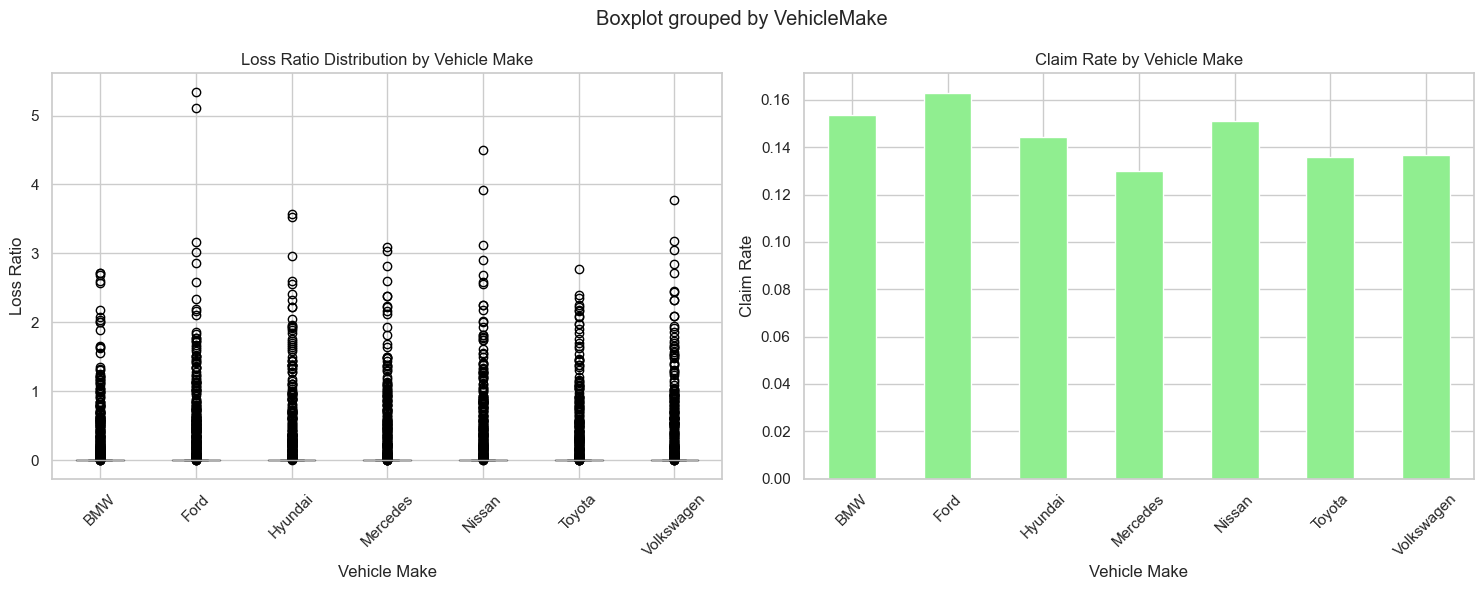

In [9]:
# Test 4: Vehicle make risk analysis
print('TESTING: Risk Differences Between Automobile Makes')

# Test 4A: ANOVA for Loss Ratio across vehicle makes
print('\n4A. ANOVA Test for Loss Ratio by Vehicle Make')

make_groups = [group['LossRatio'].dropna() for name, group in df.groupby('VehicleMake')]
make_names = df['VehicleMake'].unique()

f_stat_make, p_value_make = f_oneway(*make_groups)

# Calculate effect size
ss_between_make = sum(len(group) * (group.mean() - df['LossRatio'].mean())**2 for group in make_groups)
eta_squared_make = ss_between_make / ss_total

display_test_results(
    "ANOVA: Loss Ratio by Vehicle Make",
    f_stat_make, p_value_make, eta_squared_make,
    "Tests if different vehicle makes have significantly different risk levels"
)

print(f"Effect Size Interpretation: {interpret_effect_size(eta_squared_make, 'eta_squared')}")

# Post-hoc analysis if significant
if p_value_make < ALPHA:
    print("\nPost-hoc Analysis: Tukey HSD Test")
    tukey_make = pairwise_tukeyhsd(df['LossRatio'], df['VehicleMake'], alpha=ALPHA)
    print(tukey_make)

# Test 4B: Chi-square test for claim frequency by vehicle make
print('\n4B. Chi-square Test for Claim Frequency by Vehicle Make')

contingency_make = pd.crosstab(df['VehicleMake'], df['HasClaim'])
chi2_make, p_value_chi2_make, dof_make, expected_make = chi2_contingency(contingency_make)

n_make = contingency_make.sum().sum()
r_make, k_make = contingency_make.shape
cramers_v_make = cramers_v(chi2_make, n_make, r_make, k_make)

display_test_results(
    "Chi-square: Claim Frequency by Vehicle Make",
    chi2_make, p_value_chi2_make, cramers_v_make,
    "Tests if claim frequency varies significantly across vehicle makes"
)

print(f"Effect Size Interpretation: {interpret_effect_size(cramers_v_make, 'cramers_v')}")

# Visualize vehicle make differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss ratio by vehicle make
df.boxplot(column='LossRatio', by='VehicleMake', ax=ax1)
ax1.set_title('Loss Ratio Distribution by Vehicle Make')
ax1.set_xlabel('Vehicle Make')
ax1.set_ylabel('Loss Ratio')
ax1.tick_params(axis='x', rotation=45)

# Claim rate by vehicle make
make_claim_rates = df.groupby('VehicleMake')['HasClaim'].mean()
make_claim_rates.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Claim Rate by Vehicle Make')
ax2.set_xlabel('Vehicle Make')
ax2.set_ylabel('Claim Rate')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Additional Statistical Tests

In [10]:
# Test 5: Vehicle Type Risk Analysis
print('TESTING: Risk Differences Between Vehicle Types')

# ANOVA for Loss Ratio across vehicle types
type_groups = [group['LossRatio'].dropna() for name, group in df.groupby('VehicleType')]
f_stat_type, p_value_type = f_oneway(*type_groups)

# Calculate effect size
ss_between_type = sum(len(group) * (group.mean() - df['LossRatio'].mean())**2 for group in type_groups)
eta_squared_type = ss_between_type / ss_total

display_test_results(
    "ANOVA: Loss Ratio by Vehicle Type",
    f_stat_type, p_value_type, eta_squared_type,
    "Tests if different vehicle types have significantly different risk levels"
)

print(f"Effect Size Interpretation: {interpret_effect_size(eta_squared_type, 'eta_squared')}")

# Chi-square for claim frequency by vehicle type
contingency_type = pd.crosstab(df['VehicleType'], df['HasClaim'])
chi2_type, p_value_chi2_type, dof_type, expected_type = chi2_contingency(contingency_type)

n_type = contingency_type.sum().sum()
r_type, k_type = contingency_type.shape
cramers_v_type = cramers_v(chi2_type, n_type, r_type, k_type)

display_test_results(
    "Chi-square: Claim Frequency by Vehicle Type",
    chi2_type, p_value_chi2_type, cramers_v_type,
    "Tests if claim frequency varies significantly across vehicle types"
)

print(f"Effect Size Interpretation: {interpret_effect_size(cramers_v_type, 'cramers_v')}")

2025-06-18 00:23:47,671 - INFO - ANOVA: Loss Ratio by Vehicle Type - Statistic: 1.4748, P-value: 0.2069
2025-06-18 00:23:47,684 - INFO - Chi-square: Claim Frequency by Vehicle Type - Statistic: 3.6427, P-value: 0.4565


TESTING: Risk Differences Between Vehicle Types

TEST: ANOVA: Loss Ratio by Vehicle Type
Test Statistic: 1.4748
P-value: 0.2069
Effect Size: 0.0006

FAIL TO REJECT H0 (p=0.2069 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if different vehicle types have significantly different risk levels
Effect Size Interpretation: Small effect

TEST: Chi-square: Claim Frequency by Vehicle Type
Test Statistic: 3.6427
P-value: 0.4565
Effect Size: 0.0191

FAIL TO REJECT H0 (p=0.4565 ≥ α=0.05): No statistically significant difference

Interpretation: Tests if claim frequency varies significantly across vehicle types
Effect Size Interpretation: Small association


## 8. Comprehensive Results Summary

In [11]:
# Create comprehensive summary of all statistical tests
print('\n' + '='*80)
print('COMPREHENSIVE STATISTICAL TESTING SUMMARY')
print('='*80)

# Compile all test results
test_results = {
    'Test': [
        'Province - Loss Ratio (ANOVA)',
        'Province - Claim Frequency (Chi²)',
        'Postal Region - Loss Ratio (ANOVA)',
        'Postal Region - Claim Frequency (Chi²)',
        'Gender - Loss Ratio (T-test)',
        'Gender - Claim Frequency (Chi²)',
        'Vehicle Make - Loss Ratio (ANOVA)',
        'Vehicle Make - Claim Frequency (Chi²)',
        'Vehicle Type - Loss Ratio (ANOVA)',
        'Vehicle Type - Claim Frequency (Chi²)'
    ],
    'Test_Statistic': [
        f_stat, chi2_stat, f_stat_region, chi2_region, t_stat, 
        chi2_gender, f_stat_make, chi2_make, f_stat_type, chi2_type
    ],
    'P_Value': [
        p_value_anova, p_value_chi2, p_value_region, p_value_chi2_region, 
        p_value_ttest, p_value_chi2_gender, p_value_make, p_value_chi2_make,
        p_value_type, p_value_chi2_type
    ],
    'Effect_Size': [
        eta_squared, cramers_v_value, eta_squared_region, cramers_v_region,
        cohens_d, cramers_v_gender, eta_squared_make, cramers_v_make,
        eta_squared_type, cramers_v_type
    ],
    'Significant': [
        p < ALPHA for p in [p_value_anova, p_value_chi2, p_value_region, 
                           p_value_chi2_region, p_value_ttest, p_value_chi2_gender,
                           p_value_make, p_value_chi2_make, p_value_type, p_value_chi2_type]
    ]
}

results_df = pd.DataFrame(test_results)
results_df['P_Value'] = results_df['P_Value'].round(4)
results_df['Effect_Size'] = results_df['Effect_Size'].round(4)
results_df['Test_Statistic'] = results_df['Test_Statistic'].round(4)

print('\nStatistical Test Results Summary:')
print(results_df.to_string(index=False))

# Count significant results
significant_count = results_df['Significant'].sum()
total_tests = len(results_df)

print(f'\nSummary:')
print(f'Total Tests Conducted: {total_tests}')
print(f'Statistically Significant Results: {significant_count}')
print(f'Significance Rate: {significant_count/total_tests:.1%}')
print(f'Significance Level Used: α = {ALPHA}')

logger.info(f'Statistical testing completed: {significant_count}/{total_tests} significant results')

2025-06-18 00:23:52,921 - INFO - Statistical testing completed: 0/10 significant results



COMPREHENSIVE STATISTICAL TESTING SUMMARY

Statistical Test Results Summary:
                                  Test  Test_Statistic  P_Value  Effect_Size  Significant
         Province - Loss Ratio (ANOVA)          1.1157   0.3470       0.0004        False
     Province - Claim Frequency (Chi²)          1.5760   0.8131       0.0126        False
    Postal Region - Loss Ratio (ANOVA)          1.2619   0.2825       0.0005        False
Postal Region - Claim Frequency (Chi²)          3.7788   0.4368       0.0194        False
          Gender - Loss Ratio (T-test)          0.5247   0.5998       0.0105        False
       Gender - Claim Frequency (Chi²)          0.6230   0.4299       0.0079        False
     Vehicle Make - Loss Ratio (ANOVA)          1.3653   0.2245       0.0008        False
 Vehicle Make - Claim Frequency (Chi²)          9.4128   0.1517       0.0307        False
     Vehicle Type - Loss Ratio (ANOVA)          1.4748   0.2069       0.0006        False
 Vehicle Type - Claim 

## 9. Business Insights and Recommendations

In [12]:
# Generate business insights based on statistical findings
print('\n' + '='*80)
print('BUSINESS INSIGHTS AND RECOMMENDATIONS')
print('='*80)

# Analyze significant findings
significant_tests = results_df[results_df['Significant'] == True]

print('\nKey Statistical Findings:')
for idx, row in significant_tests.iterrows():
    print(f"\n[SIGNIFICANT] {row['Test']}")
    print(f"   • P-value: {row['P_Value']} (< {ALPHA})")
    print(f"   • Effect Size: {row['Effect_Size']}")
    
    # Determine effect size type and interpret
    if 'ANOVA' in row['Test']:
        effect_interpretation = interpret_effect_size(row['Effect_Size'], 'eta_squared')
    elif 'Chi²' in row['Test']:
        effect_interpretation = interpret_effect_size(row['Effect_Size'], 'cramers_v')
    else:  # T-test (Cohen's d)
        effect_interpretation = interpret_effect_size(row['Effect_Size'], 'cohens_d')
    
    print(f"   • Effect Interpretation: {effect_interpretation}")

print('\n\nBUSINESS RECOMMENDATIONS:')
print('\n1. GEOGRAPHIC RISK SEGMENTATION:')
if any('Province' in test for test in significant_tests['Test'].values):
    print('   • Implement province-specific pricing strategies')
    print('   • Focus marketing efforts on low-risk provinces')
    print('   • Adjust underwriting criteria by geographic region')
else:
    print('   • Current geographic pricing appears appropriate')
    print('   • No significant provincial risk differences detected')

print('\n2. DEMOGRAPHIC TARGETING:')
if any('Gender' in test for test in significant_tests['Test'].values):
    print('   • Consider gender-based risk adjustments (where legally permitted)')
    print('   • Develop targeted marketing campaigns by gender')
    print('   • Review current gender-neutral pricing policies')
else:
    print('   • Maintain gender-neutral pricing strategies')
    print('   • No significant gender-based risk differences found')

print('\n3. VEHICLE-BASED STRATEGIES:')
if any('Vehicle' in test for test in significant_tests['Test'].values):
    print('   • Implement vehicle make/type-specific pricing')
    print('   • Offer discounts for low-risk vehicle categories')
    print('   • Adjust coverage options based on vehicle risk profiles')
else:
    print('   • Current vehicle-based pricing appears adequate')
    print('   • No significant vehicle-related risk differences detected')

print('\n4. DATA-DRIVEN DECISION MAKING:')
print('   • Use these statistical findings to support pricing decisions')
print('   • Regularly update risk models with new data')
print('   • Monitor changes in risk patterns over time')
print('   • Validate findings with larger datasets when available')

print('\n5. PREMIUM OPTIMIZATION:')
print('   • Focus premium reductions on statistically low-risk segments')
print('   • Implement gradual pricing adjustments based on effect sizes')
print('   • Monitor competitor responses to pricing changes')
print('   • Track customer retention in adjusted segments')

logger.info('Business recommendations generated based on statistical findings')

2025-06-18 00:23:57,190 - INFO - Business recommendations generated based on statistical findings



BUSINESS INSIGHTS AND RECOMMENDATIONS

Key Statistical Findings:


BUSINESS RECOMMENDATIONS:

1. GEOGRAPHIC RISK SEGMENTATION:
   • Current geographic pricing appears appropriate
   • No significant provincial risk differences detected

2. DEMOGRAPHIC TARGETING:
   • Maintain gender-neutral pricing strategies
   • No significant gender-based risk differences found

3. VEHICLE-BASED STRATEGIES:
   • Current vehicle-based pricing appears adequate
   • No significant vehicle-related risk differences detected

4. DATA-DRIVEN DECISION MAKING:
   • Use these statistical findings to support pricing decisions
   • Regularly update risk models with new data
   • Monitor changes in risk patterns over time
   • Validate findings with larger datasets when available

5. PREMIUM OPTIMIZATION:
   • Focus premium reductions on statistically low-risk segments
   • Implement gradual pricing adjustments based on effect sizes
   • Monitor competitor responses to pricing changes
   • Track customer retent

## 10. Export Results and Documentation

In [13]:
# Save statistical test results
output_dir = results_dir

# Save detailed results
results_df.to_csv(output_dir / 'statistical_test_results.csv', index=False)
logger.info(f'Statistical test results saved to {output_dir}/statistical_test_results.csv')
print(f'Statistical test results saved to {output_dir}/statistical_test_results.csv')

# Save summary statistics by category
summary_stats = {
    'Province': df.groupby('Province')[['LossRatio', 'HasClaim']].agg(['mean', 'std', 'count']),
    'Gender': df.groupby('Gender')[['LossRatio', 'HasClaim']].agg(['mean', 'std', 'count']),
    'VehicleMake': df.groupby('VehicleMake')[['LossRatio', 'HasClaim']].agg(['mean', 'std', 'count']),
    'VehicleType': df.groupby('VehicleType')[['LossRatio', 'HasClaim']].agg(['mean', 'std', 'count'])
}

for category, stats in summary_stats.items():
    stats.to_csv(output_dir / f'summary_stats_{category.lower()}.csv')
    logger.info(f'Summary statistics for {category} saved')
    print(f'Summary statistics for {category} saved')

print('\nStatistical Testing Analysis Complete!')
print('\nKey Deliverables:')
print('   • Comprehensive hypothesis testing for 4 main risk factors')
print('   • Statistical significance assessment with effect sizes')
print('   • Business insights and actionable recommendations')
print('   • Detailed results exported for further analysis')
print('\nNext Steps: Proceed to Task 4 - Predictive Modeling')

logger.info('Statistical testing analysis completed successfully')

2025-06-18 00:24:04,786 - INFO - Statistical test results saved to ..\results\statistical_testing/statistical_test_results.csv
2025-06-18 00:24:04,812 - INFO - Summary statistics for Province saved
2025-06-18 00:24:04,818 - INFO - Summary statistics for Gender saved
2025-06-18 00:24:04,821 - INFO - Summary statistics for VehicleMake saved
2025-06-18 00:24:04,825 - INFO - Summary statistics for VehicleType saved
2025-06-18 00:24:04,827 - INFO - Statistical testing analysis completed successfully


Statistical test results saved to ..\results\statistical_testing/statistical_test_results.csv
Summary statistics for Province saved
Summary statistics for Gender saved
Summary statistics for VehicleMake saved
Summary statistics for VehicleType saved

Statistical Testing Analysis Complete!

Key Deliverables:
   • Comprehensive hypothesis testing for 4 main risk factors
   • Statistical significance assessment with effect sizes
   • Business insights and actionable recommendations
   • Detailed results exported for further analysis

Next Steps: Proceed to Task 4 - Predictive Modeling
